# Gaussian Model

## Swaption pricing

The swaption price at time 0, $V_0$, is given by the following expression $$
    \begin{array}{ll} V_0 &= \mathbb{E}_{\mathbb{Q}}\Big[e^{-\int_{0}^{T_0} r(s) \ \mathrm{d}s}Swap(T_0)^+\Big] \\
&= P(0,T_0) \ \mathbb{E}_{\mathbb{Q}}\Big[e^{-\int_{0}^{T_0} x(s) \ \mathrm{d}s}\Big(1-P(T_0,T_N,x(T_0),y(T_0))-K\sum_{n=0}^{N-1} \tau_n P(T_0,T_{n+1},x(T_0),y(T_0)\Big)^+\Big]
\end{array}
$$
And $$\forall n \in [|0,N|], \quad P(T_0,T_n,x,y) = \frac{P(0,T_n)}{P(0,T_0)} e^{-G(T_0,T_N)x-\frac{1}{2}G(T_0,T_N)^2 y}$$

One will use a Monte Carlo estimator of the expectation above by using M independent simulations $S_m$ so that
$$\hat{V_0} = \frac{1}{M} \sum_{m=1}^M S_m$$
$$\forall m, \ S_m = e^{I_m} \ \Big(P(0,T_0)-P(0,T_0)P(T_0,T_n,x_m,y_m) - KP(0,T_0) A(T_0,x_m,y_m)\Big)^+$$
Where we have noted $x_m,y_m,I_m$ the m-th Euler simulation of $x(T_0),y(T_0), I(T_0)$

## Euler discretization

We aim to discretize the following differential system with an Euler scheme

$$\left\{
    \begin{array}{ll}
       \mathrm{d}x(t) &= (y(t) - \chi(t) x(t)) \ \mathrm{d}t \ + \ \sigma_r(t) \ \mathrm{d}Wt\\
       \mathrm{d}y(t) &= (\sigma_r(t)^2-2\chi(t)y(t)) \ \mathrm{d}t
    \end{array}
\right.$$

**Constant mean reversion and linear local volatility:** First, let for simplicity $$\chi(t) = \chi \in \mathbb{R}$$ and $$\sigma_r(t) = \sigma_r(t,x(t),y(t)) = \lambda(a + bx(t))$$

One defines a discretized time interval $0=t_0 < t_1 < ... < t_N = T_0$ and $\forall i \in [|0,N-1|], \ \Delta_i = t_{i+1} -t_i$

We will simulate $x(T_O)$ and $y(T_O)$ thanks to the scheme:
$$\left\{
    \begin{array}{ll}
       x_{t_{i+1}} &= x_{t_i} + (y_{t_i} - \chi x_{t_i}) \ \Delta_i \ + \ \lambda(a+bx_{t_i}) \ \sqrt{\Delta_i} Z_i \qquad  ,Z_i \sim \mathcal{N}(0,1) \\
       y_{t_{i+1}} &= y_{t_i} + (\lambda^2(a+bx_{t_i})^2-2\chi y_{t_i}) \ \Delta_i
    \end{array}
\right.$$

What's more, one has to simulate the variable $$I(T_0)=-\int_{0}^{T_0} x(s) \ \mathrm{d}s$$
As $\mathrm{d}I(t) = -x(t) \ \mathrm{d}t$, in line with the results above, one defines
$$I_{t_{i+1}} = I_{t_i} - x_{t_i} \ \Delta_i$$

**Remark:** $y(t) = \int_{0}^{t} e^{-2\chi(t-u)} (a+bx(u))^2 \ \mathrm{d}u$ is a path dependent integral and could be calculated with the values $\{x_{t_i}, \ t_i<t\}$

## Simulation

In order to price swaptions, one needs the values of the zero coupon bonds for each maturity $\Big(P(0,T_i)\Big)_{i=0,N}$. One can calculate it with $$P(0,T_i) = e^{-\int_{0}^{T_i}f(0,u) \ \mathrm{d}u}$$, but one needs again **the initial forward curve** $t \rightarrow f(0,t)$


To do some calculations and to have a first simple approach, I have chosen to fixe $P(0,T) = e^{-rT}$ even if it's completely wrong in our model because the short rate is stochastic.

In [1]:
#modules

import numpy as np
import math
from random import *
from time import time
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(10)

In [7]:
# One set the parameters
chi = 1
lmbda = 1
a = 1
b = 0
K = 1
N = 20
M = 10000
r = 1
maturities = np.arange(0.5,5)     #tenor structure of the underlying swap T0=1,2...6=TN
T0 = maturities[0]
bonds = [np.exp(-r*m) for m in maturities]  #P(0,T_i) fixed to exp(-T_i) for tests

In [3]:
#Simulation of the diffusions x,y,I
#delta is the time grid of the discretization

def simul(lmbda,a,b,chi,delta):
    N = delta.size
    (x,y,I) =(0,0,0)
    for i in range(N-1):
        delta_i = delta[i+1]-delta[i]
        sigma_i = lmbda*(a+b*x)
        Z = float(np.random.standard_normal(1))
        I = I - x*delta_i
        x = x +(y-chi*x)*delta_i + sigma_i*math.sqrt(delta_i)*Z
        y = y + (sigma_i**2 -2*chi*y)*delta_i
    return [x,y,I]

In [8]:
#test
delta = np.linspace(0,T0,N+1)
s = simul(lmbda,a,b,chi,delta)
(x,y,I) = (s[0],s[1],s[2])
print(x,y,I)

0.6559682936372841 0.32075703879572887 -0.14451091498710805


In [9]:
#function G 
def G(t,T,chi):
    return (1-np.exp(chi*(t-T)))/chi

#payoff of the swaption at T0
def payoff_swaption(maturities,bonds,x,y,chi,K):
    T0 = maturities[0]                             #maturities = [T0,...,TN]
    nb_maturities = maturities.size
    A = 0
    #calculate the annuity A
    for n in range(nb_maturities-1):
        g = G(T0,maturities[n+1],chi)
        A += (maturities[n+1]-maturities[n])*bonds[n+1]*np.exp(-1*g*x-0.5*y*g**2)
    g = G(T0,maturities[-1],chi)
    swap = bonds[0] - bonds[-1]*np.exp(-1*g*x-0.5*y*g**2) - K*A
    if swap>0:
        return swap
    else:
        return 0

In [10]:
#test

payoff_swaption(maturities,bonds,x,y,chi,K)

0.4029888871629175

In [11]:
#pricing of the swaption by Monte Carlo algorithm
#N is the parameter of discretization in the Euler scheme
#M is the number of simulations in the Monte Carlo estimation
#K is the strike of teh swaption

def swaption(M,N,T0,K,lmbda,a,b,chi,bonds,maturities):
    t1 = time()
    delta = np.linspace(0,T0,N+1)
    Monte_Carlo = 0
    for m in range(M):
        sim = simul(lmbda,a,b,chi,delta)
        (x,y,I) = (sim[0],sim[1],sim[2])
        Monte_Carlo += np.exp(I)*payoff_swaption(maturities,bonds,x,y,chi,K)
    t2 = time()
    print("Execution time: ",t2-t1, "sec")
    return Monte_Carlo/M

In [12]:
#tests
swaption(M,N,T0,K,lmbda,a,b,chi,bonds,maturities)

Execution time:  4.608523607254028 sec


0.2590558435912049

## Effect of volatility's parameters

Execution time:  4.672131538391113 sec
Execution time:  4.385974645614624 sec
Execution time:  4.460890769958496 sec
Execution time:  4.1956212520599365 sec
Execution time:  4.113009214401245 sec
Execution time:  4.347233295440674 sec


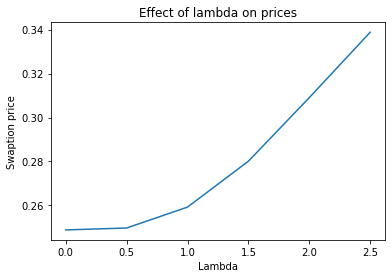

In [13]:
lmbdas = np.arange(0,3,0.5)

swaptions1 = [swaption(M,N,T0,K,l,a,b,chi,bonds,maturities) for l in lmbdas]
plt.figure()
plt.xlabel('Lambda')
plt.ylabel('Swaption price')
plt.title('Effect of lambda on prices')
plt.plot(lmbdas,swaptions1)
plt.show()

Execution time:  3.104661703109741 sec
Execution time:  2.9256393909454346 sec
Execution time:  2.8272581100463867 sec
Execution time:  3.2067902088165283 sec
Execution time:  2.945539951324463 sec
Execution time:  2.7980005741119385 sec
Execution time:  2.7883999347686768 sec
Execution time:  2.8382644653320312 sec


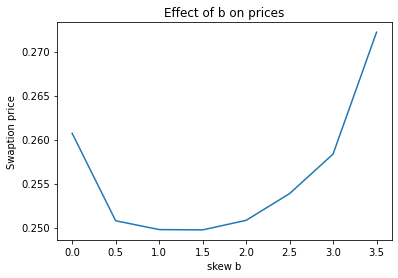

In [11]:
b_val = np.arange(0,4,0.5)

swaptions2 = [swaption(M,N,T0,K,lmbda,a,b,chi,bonds,maturities) for b in b_val]
plt.figure()
plt.xlabel('skew b')
plt.ylabel('Swaption price')
plt.title('Effect of b on prices')
plt.plot(b_val,swaptions2)
plt.show()

**Observation: As expected, an increase in $\lambda$ and b leads to an increase in the short rate volatility and then in the swaption volatility.**

Execution time:  2.9679384231567383 sec
Execution time:  2.9655535221099854 sec
Execution time:  2.823681116104126 sec
Execution time:  2.814521312713623 sec
Execution time:  2.8553049564361572 sec
Execution time:  2.8775105476379395 sec
Execution time:  2.8511106967926025 sec
Execution time:  2.885974884033203 sec
Execution time:  2.8101420402526855 sec
Execution time:  3.0466668605804443 sec


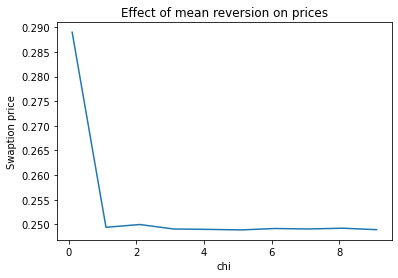

In [12]:
mean_reversion_val = np.arange(0.1,10,1)

swaptions = [swaption(M,N,T0,K,lmbda,a,b,mr,bonds,maturities) for mr in mean_reversion_val]
plt.figure()
plt.xlabel('chi')
plt.ylabel('Swaption price')
plt.title('Effect of mean reversion on prices')
plt.plot(mean_reversion_val,swaptions)
plt.show()

**Remark:** One observes that the swaption volatility decreases as the mean reversion increases as it is said p. 553 in Piterbarg. Indeed, the mean reversion parameter tends to keep the factor x around a mean level

## Implied volatility

Assume that the swap rate $S$ is log-normal. We have the following diffusion $$\mathrm{d}S_{T0,...,T_N}(t) = S_{T0,...,T_N}(t)\sigma \ \mathrm{d}W_t$$ because it has to be a martingale under $\mathbb{Q}^A$ where $$\frac{\mathrm{d}\mathbb{Q}^A}{\mathrm{d}\mathbb{Q}}\Big| _{\mathcal{F}_t} = \frac{A(t)}{A(0)} e^{-\int_{0}^{t} r(s) \ \mathrm{d}s}$$

Hence $$\begin{array}{ll} V_0 &= \mathbb{E}_{\mathbb{Q}}\Big[ e^{-\int_{0}^{t} r(s) \ \mathrm{d}s} Swap(T_0)^+ \Big]
= A(0) \mathbb{E}_{\mathbb{Q}^A}\Big[ \big(S(T_0) -K \big) \mathbb{1}_{S(T_0)>K} \Big] \end{array}$$

Let $$\frac{\mathrm{d}\tilde{\mathbb{Q}}}{\mathrm{d}\mathbb{Q}^A} = \frac{S(T_0)}{\mathbb{E}[S(T_0)]} = e^{-\frac{\sigma^2}{2}T_0 + \sigma W_{T_0}}$$ and by Girsanov's Theorem, $$\tilde{W}_t = W^A_t - \sigma t$$ is a Brownian motion under $\tilde{\mathbb{Q}}$.

It leads to a Black Scholes formula by:
$$\begin{array}{ll} V_0 &= A(0)S(0) \tilde{\mathbb{Q}} \Big( e^{\frac{\sigma^2}{2}T_0 + \sigma \tilde{W}_{T_0}} > K \Big) \ -K A(0) \mathbb{Q}^A \Big( \sigma W_{T_0} > \ln{\frac{K}{S(0)}} + \frac{\sigma^2}{2} T_0 \Big) \\
&= \boxed{A(0)S(0) \Phi(d^+) \ -KA(0) \Phi(d^-)}
\end{array}$$

$$\left\{
    \begin{array}{ll}
       d^+ &= \frac{\ln{\frac{S(0)}{K}} + \frac{\sigma^2}{2} T_0}{\sigma \sqrt{T_0}} \\
       d^- &= d^+ - \sigma \sqrt{T_0}
    \end{array}
\right.$$

In particular, $\frac{\partial d^+}{\partial \sigma} = \frac{\partial d^-}{\partial \sigma} + \sqrt{T_0}$ and 
$$vega = \frac{\partial V_0}{\partial \sigma} = A(0)S(0) \frac{\partial d^+}{\partial \sigma} \phi(d^+) \ -K A(0) \frac{\partial d^-}{\partial \sigma} \phi(d^-) \\
= A(0)S(0) \sqrt{\frac{T_0}{2\pi}} e^{-\frac{(d^+)^2}{2}}$$ ($\Phi$ is the cdf of the standard normal law and $\phi$ its density function.)

First view of Black scholes prices to be sure that the pricing formula is right and that the asymptotic behavior is the expected one, i.e $V_0 \rightarrow_{\sigma \to \infty} A(0)S(0)$

SO*A0= 0.5954216631743912


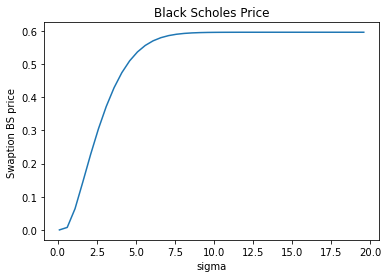

In [14]:
#Black Scholes Price

def Price_BS(S0,A0,T0,K,sigma):
    d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
    return S0*A0* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))

T0 = maturities[0]
nb_maturities = maturities.size
A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
S0 = (bonds[0]-bonds[-1])/A0
sigma_val = np.arange(0.1,20,0.5)
BS_prices = [Price_BS(S0,A0,T0,2*S0,s) for s in sigma_val]
print('SO*A0=',S0*A0)

plt.figure()
plt.xlabel('sigma')
plt.title('Black Scholes Price')
plt.ylabel('Swaption BS price ')
plt.plot(sigma_val,BS_prices)
plt.show()

### Newton-Raphson algorithm

The simple Newton-Raphson algorithm, applied to find the zero of the function $\sigma \rightarrow V_0(\sigma) - \hat{V}$ where $\hat{V}$ is the observed marked to market value of the swaption, is written:

$$\left\{
    \begin{array}{ll}
       \sigma_0 \quad \text{chosen}\\
       \sigma_{n+1} = \sigma_n - \bigg( \frac{V_0(\sigma_n) - \hat{V}}{\frac{\partial V_0}{\partial \sigma}(\sigma_n)} \bigg)
    \end{array}
\right.$$

In [15]:
def Newton_Raphson(sigma0, nb_it, Mtm, bonds, K, maturities):
    sigma = sigma0
    T0 = maturities[0]   
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0
    
    for i in range(nb_it):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        price_BS = (bonds[0]-bonds[-1])* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))
        derivative = (bonds[0]-bonds[-1])*np.sqrt(T0/(2*np.pi))*np.exp(-0.5*d**2)
        sigma = sigma - (price_BS-Mtm)/derivative
        #print("Sigma, derivative =",sigma, derivative)
    return sigma

Newton_Raphson(0.1,10,0.05,bonds,2,maturities)

0.5019064713365248

There is some instability with the Newton-Raphson algorithm because the derivative of the Black Scholes price tends to be very small.

### Dichotomie

In [16]:
def bissectrice(nb_it, Mtm, bonds, K, maturities):
    T0 = maturities[0]   
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0

    x = 0
    y = 1
    for i in range(nb_it):
        z = (x+y)/2
        sigma = z/(1-z)
        price_BS = Price_BS(S0,A0,T0,K,sigma)

        if(Mtm > price_BS):
            x = z
        else:
            y = z
    z = (x+y)/2
    return z/(1-z)

bissectrice(10,0.05,bonds,2,maturities)

0.5025678650036683

In [17]:
# méthode bissectrice de Python

def biss_python(Mtm, bonds, K, maturities):
    T0 = maturities[0] 
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0
    return opt.bisect(lambda x: Price_BS(S0,A0,T0,K,x) - Mtm, 0.01, 10)


### Python's algorithm

In [18]:
#Brent's method

def Brent(Mtm, bonds, K, maturities):
    T0 = maturities[0] 
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0
    f = lambda x: Price_BS(S0,A0,T0,K,x) - Mtm
    return opt.brentq(f, 0.001, 20)


This algorithm is efficient but stops wether $f(a)f(b)>0$ at one moment

In [19]:
#Essai sur un prix BS avec sigma connu et comparaison des méthodes

sigma = 0.5
nb_maturities = maturities.size
A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
S0 = (bonds[0]-bonds[-1])/A0 
Market_price = Price_BS(S0,A0,T0,2,sigma)

New_vol = Newton_Raphson(0.1, 5, Market_price, bonds, 2, maturities)
bissec_vol = bissectrice(10, Market_price, bonds, 2, maturities)
python_vol = biss_python(Market_price,bonds,2,maturities)
Brent_vol = Brent(Market_price,bonds,2,maturities)
print("Vol BS:", sigma,"Implied vol Newton:",New_vol,"Implied vol Bissec:",bissec_vol,"Implied vol python", python_vol,"Implied vol Brent: ",Brent_vol
)

Vol BS: 0.5 Implied vol Newton: 0.50000042343507 Implied vol Bissec: 0.5003663003663004 Implied vol python 0.5000000000008197 Implied vol Brent:  0.49999999999992195


### Effect of K

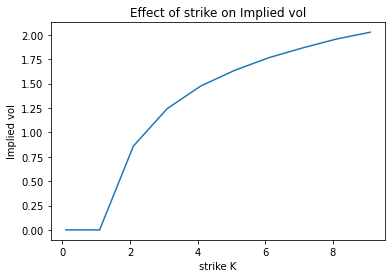

In [20]:
strikes = np.arange(0.1,10,1)
impli_vol = [bissectrice(10,0.1,bonds,k,maturities) for k in strikes]
plt.figure()
plt.xlabel('strike K')
plt.ylabel('Implied vol')
plt.title('Effect of strike on Implied vol')
plt.plot(strikes,impli_vol)
plt.show()

**Explanation:** One should have an implied volatility surface which is decreasing with respect to strike K, but this phenomenon is justified by the fact that input price is the same for all values of K and is 'randomly' chosen. Indeed Black & Scholes price is decreasing with respect to K: $$\frac{\partial V_0}{\partial K} = A(0)S(0) \frac{\partial d^+}{\partial K} \phi(d^+) \ -A(0)K \frac{\partial d^-}{\partial K} \phi(d^-) - A(0) \Phi(d^-)$$

And $\frac{\partial d^+}{\partial K} = \frac{\partial d^-}{\partial K} = \frac{-1}{\sigma \sqrt{T_0}K}$
So $$\frac{\partial V_0}{\partial K} = \frac{-A(0)}{\sigma\sqrt{T_0}} \Big( \frac{S(0)}{K}\phi(d^+)-\phi(d^+-\sigma\sqrt{T_0}) \Big) \ -A(0) \Phi(d^-) = -A(0) \Phi(d^-) \ \le 0$$

Hence if $K_1 \le K_2, \quad \hat{V} = V_0(K_1,\sigma_1) = V_0(K_2,\sigma_2)$ then $\sigma_2 \ge \sigma_1$ which explains the behavior of the curve above.

### Effect of T0

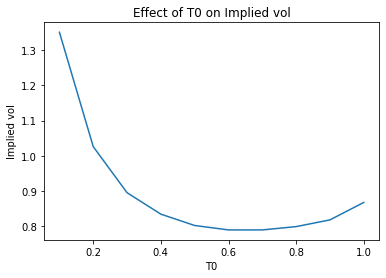

In [22]:
T0s = np.arange(0.1,1.1,0.1)
impli_vol = [bissectrice(10,0.1,[np.exp(-r*m) for m in np.arange(t,5)],2,np.arange(t,5)) for t in T0s]
plt.figure()
plt.xlabel('T0')
plt.ylabel('Implied vol')
plt.title('Effect of T0 on Implied vol')
plt.plot(T0s,impli_vol)
plt.show()

### Reliability of bissection method
One will input a swaption price calculated by the Black & Scholes formula for a known volatility. The generated surface is then supposed to be flat and equal to this level of volatility. It is a way to check if the inversion method is unstable somewhere.

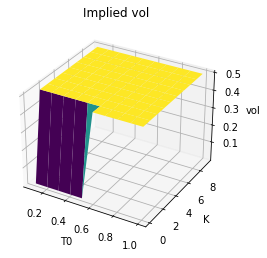

In [23]:
#from a BS price with sigma known --> flat curve is theory

X,Y = np.meshgrid(T0s, strikes)
sigma = 0.5
Z = np.zeros((strikes.size,T0s.size))
i,j= 0,0
for k in strikes:
    for t in T0s:
        maturities = np.arange(t,5)
        bonds = [np.exp(-r*m) for m in maturities]
        nb_maturities = maturities.size
        A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
        S0 = (bonds[0]-bonds[-1])/A0
        Z[i][j] = bissectrice(10,Price_BS(S0,A0,t,k,sigma), bonds, k, maturities)
        #Z[i][j] = Brent(Price_BS(S0,A0,t,k,sigma), bonds, k, maturities)
        j = (j+1)%10
    i+=1
        
#Z = np.array([[bissectrice(10,Price_BS(S0,A0,t,k,sigma),[np.exp(-r*m) for m in np.arange(t,5)],k,np.arange(t,5)) for t in T0s] for k in strikes])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('T0')
ax.set_ylabel('K')
ax.set_zlabel('vol')
ax.set_title('Implied vol');

**Remark:** It can be osbserved that the implied volatility surface is flat almost everywhere. However implied volatility seems to vanish for low levels of $K$ and $T_0$. The lower the input volatility is, the more important is the unstability.

In [24]:
#Ploting function of the implied volatility surface

def plot_3D(T0s, strikes, Mtm):
    X,Y = np.meshgrid(T0s, strikes)
    Z = np.array([[bissectrice(10,Mtm, [np.exp(-r*m) for m in np.arange(t,5)], k, np.arange(t,5)) for t in T0s] for k in strikes])
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('T0')
    ax.set_ylabel('K')
    ax.set_zlabel('vol')
    ax.set_title('Implied vol for Price=' + str(Mtm));

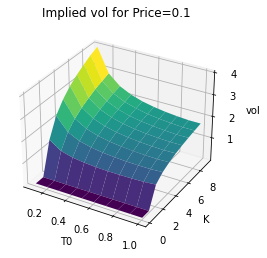

In [25]:
plot_3D(T0s,strikes,0.1)

Execution time:  4.506011962890625 sec
Execution time:  3.995288372039795 sec
Execution time:  4.043997049331665 sec


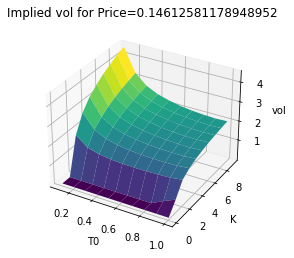

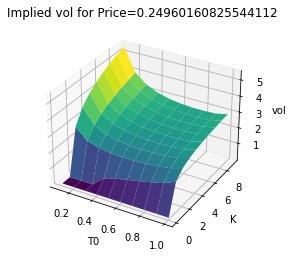

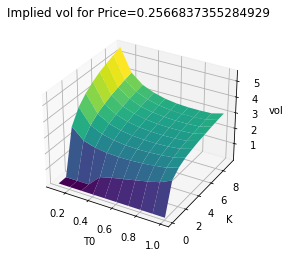

In [26]:
#Tests with different a
Mtm1 = swaption(M,N,T0,K,lmbda,0,b,chi,bonds,maturities)
plot_3D(T0s,strikes,Mtm1)
Mtm2 = swaption(M,N,T0,K,lmbda,3.7,b,chi,bonds,maturities)
plot_3D(T0s,strikes,Mtm2)
Mtm3 = swaption(M,N,T0,K,lmbda,4,b,chi,bonds,maturities)
plot_3D(T0s,strikes,Mtm3)

Execution time:  4.59572696685791 sec
Execution time:  4.397596597671509 sec
Execution time:  4.308629751205444 sec


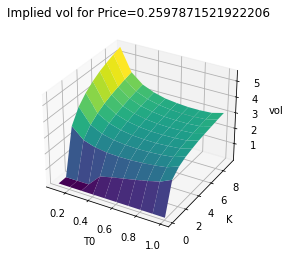

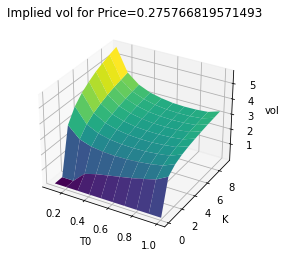

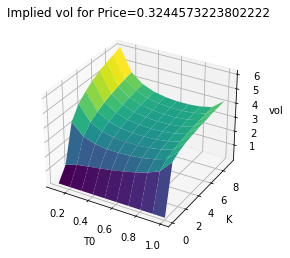

In [135]:
#Tests with different b
Mtm1 = swaption(M,N,T0,K,lmbda,a,0,chi,bonds,maturities)
plot_3D(T0s,strikes,Mtm1)
Mtm2 = swaption(M,N,T0,K,lmbda,a,5,chi,bonds,maturities)
plot_3D(T0s,strikes,Mtm2)
Mtm3 = swaption(M,N,T0,K,lmbda,a,8,chi,bonds,maturities)
plot_3D(T0s,strikes,Mtm3)

Execution time:  4.951383113861084 sec
Execution time:  4.460316181182861 sec
Execution time:  4.8040900230407715 sec


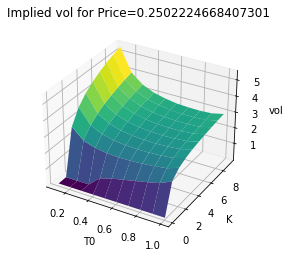

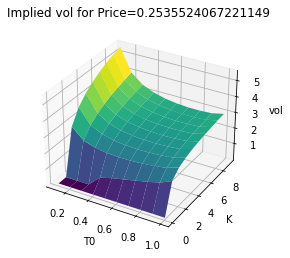

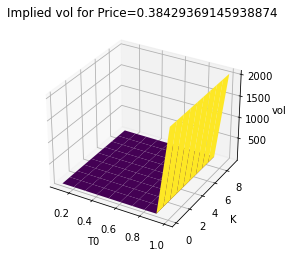

In [147]:
#Tests with different lambda
Mtm1 = swaption(M,N,T0,K,1,a,b,chi,bonds,maturities)
plot_3D(T0s,strikes,Mtm1)
Mtm2 = swaption(M,N,T0,K,2,a,b,chi,bonds,maturities)
plot_3D(T0s,strikes,Mtm2)
Mtm3 = swaption(M,N,T0,K,8,a,b,chi,bonds,maturities)
plot_3D(T0s,strikes,Mtm3)

Execution time:  4.356647729873657 sec
Execution time:  4.189858913421631 sec
Execution time:  4.336628437042236 sec


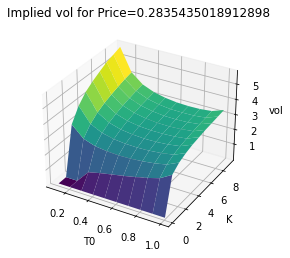

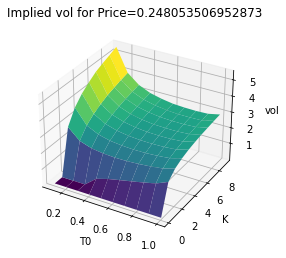

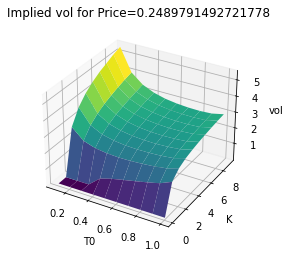

In [154]:
#Tests with different chi
Mtm1 = swaption(M,N,T0,K,lmbda,a,b,0.1,bonds,maturities)
plot_3D(T0s,strikes,Mtm1)
Mtm2 = swaption(M,N,T0,K,lmbda,a,b,3,bonds,maturities)
plot_3D(T0s,strikes,Mtm2)
Mtm3 = swaption(M,N,T0,K,lmbda,a,b,10,bonds,maturities)
plot_3D(T0s,strikes,Mtm3)

## Pricing by Gaussian swap rate approximation ( p.422 10.1.3.2)

$$V_0 \approx A(0) \Big[\big(S(0) -K \big) \Phi(d) \ + \ \sqrt{v} \phi(d) \Big] \\
d= \frac{S(0)-K}{\sqrt{v}} \quad v = \int_{0}^{T_0} q(t,\bar{x}(t))^2 \ \sigma_r(t)^2 \ \mathrm{d}t$$

Where $$q(t,x) = -\frac{P(t,T_0,x) G(t,T_0) - P(t,T_N,x)G(t,T_N)}{A(t,x)} \ + \ \frac{S(t,x)}{A(t,x)}\sum_{i=0}^{N-1} \tau_i P(t,T_{i+1},x) G(t,T_{i+1})$$

**Remark:** (To do later) Find numerical methods in order to approximate $v$